<a href="https://colab.research.google.com/github/spring-board-b2-hate-speech/Group-8/blob/main/DL%20models/LSTM_DL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Embedding using the BERT Model

Here we are making use of the "distilbert-base-uncased" model DistilBERT is a transformers model, smaller and faster than BERT. Masked language modeling,Distillation loss: the model was trained to return the same probabilities as the BERT base model.Cosine embedding loss: the model was also trained to generate hidden states as close as possible as the BERT base model.



In [ ]:


import pandas as pd
import numpy as np
from transformers import DistilBertTokenizer, TFDistilBertModel
import tensorflow as tf

train_df = pd.read_csv('Train_data.csv')
test_df = pd.read_csv('Test_data.csv')

X_train = train_df['clean_text'].tolist()
y_train = train_df['IsHatespeech'].tolist()
X_test = test_df['clean_text'].tolist()
y_test = test_df['IsHatespeech'].tolist()

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = TFDistilBertModel.from_pretrained('distilbert-base-uncased')


def get_distilbert_embeddings(texts, tokenizer, model, max_length=64):
    inputs = tokenizer(texts, return_tensors='tf', padding=True, truncation=True, max_length=max_length)
    outputs = model(inputs)
    embeddings = outputs.last_hidden_state
    return embeddings

X_train_embeddings = get_distilbert_embeddings(X_train, tokenizer, model).numpy()
X_test_embeddings = get_distilbert_embeddings(X_test, tokenizer, model).numpy()

print(f'Training data shape: {X_train_embeddings.shape}')
print(f'Test data shape: {X_test_embeddings.shape}')


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Training data shape: (7445, 64, 768)
Test data shape: (1862, 64, 768)


In [ ]:
# Shaping it so its easy to pass on to the DL Model
type(y_train)
y_train = pd.Series(y_train)
y_test = pd.Series(y_test)

### Deep Learning Model
Here the input layer is a Bidirectional LSTM which makes use oif two LSTM model so as to gather inferences from data using both directions.
Then we added another LSTM layer and some Dense layer.

##### Activation function:
Relu: is the best activation function as per the data and practice . It provide the best performance overall campared to other AF
sigmoid : Its used in the last layer because we want the classification to be Binary because its ability to squash the output between 0 and 1, which is useful for binary classification tasks.

#### Loss function and Optimizer
binary crossentropy (binary_crossentropy) is used when you have a two-class, or binary, classification problem.

Adam is better than other adaptive learning rate algorithms due to its faster convergence and robustness across problems.


Epoch 1/20
59/59 - 71s - loss: 3.0757 - accuracy: 0.7255 - val_loss: 2.4192 - val_accuracy: 0.7465 - lr: 5.0000e-04 - 71s/epoch - 1s/step
Epoch 2/20
59/59 - 62s - loss: 1.9854 - accuracy: 0.7613 - val_loss: 1.6529 - val_accuracy: 0.7368 - lr: 5.0000e-04 - 62s/epoch - 1s/step
Epoch 3/20
59/59 - 62s - loss: 1.3691 - accuracy: 0.7743 - val_loss: 1.2380 - val_accuracy: 0.7427 - lr: 5.0000e-04 - 62s/epoch - 1s/step
Epoch 4/20
59/59 - 62s - loss: 1.0112 - accuracy: 0.7883 - val_loss: 0.9404 - val_accuracy: 0.7599 - lr: 5.0000e-04 - 62s/epoch - 1s/step
Epoch 5/20
59/59 - 62s - loss: 0.8067 - accuracy: 0.7941 - val_loss: 0.7924 - val_accuracy: 0.7605 - lr: 5.0000e-04 - 62s/epoch - 1s/step
Epoch 6/20
59/59 - 62s - loss: 0.6813 - accuracy: 0.8081 - val_loss: 0.7145 - val_accuracy: 0.7583 - lr: 5.0000e-04 - 62s/epoch - 1s/step
Epoch 7/20
59/59 - 62s - loss: 0.5951 - accuracy: 0.8175 - val_loss: 0.7011 - val_accuracy: 0.7589 - lr: 5.0000e-04 - 62s/epoch - 1s/step
Epoch 8/20
59/59 - 62s - loss: 0.5

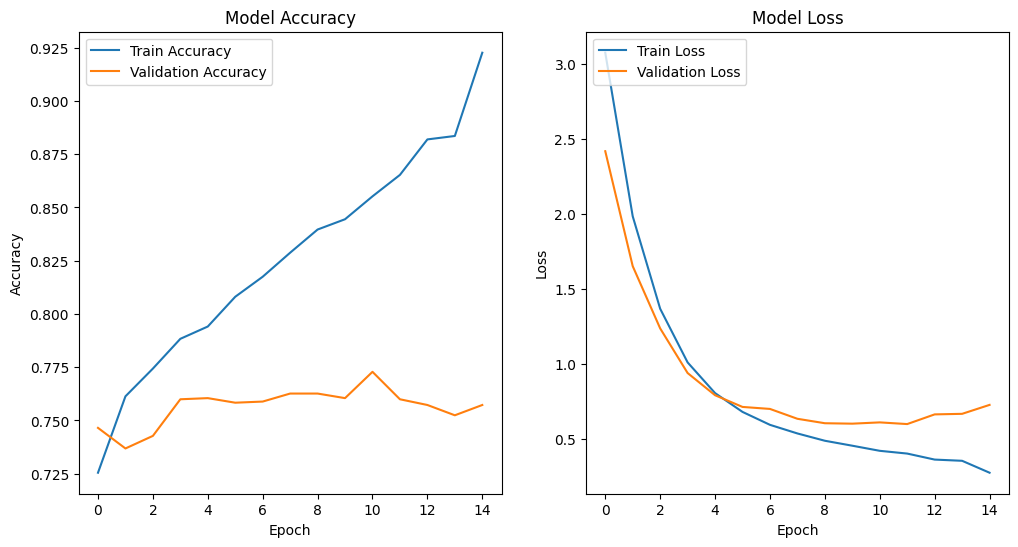

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout,Bidirectional, LSTM, GlobalMaxPooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, confusion_matrix, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

model = Sequential()
model.add(Bidirectional(LSTM(512, input_shape=(X_train_embeddings.shape[1], X_train_embeddings.shape[2]), dropout=0.3, recurrent_dropout=0.3, return_sequences=True)))
model.add(LSTM(256, dropout=0.3, recurrent_dropout=0.3))
model.add(Dense(128, activation='relu', kernel_regularizer='l2'))
model.add(Dense(64, activation='relu', kernel_regularizer='l2'))
model.add(Dense(32, activation='relu', kernel_regularizer='l2'))
model.add(Dense(16, activation='relu', kernel_regularizer='l2'))
#model.add(Dropout(0.1))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0005), metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.0001)

history = model.fit(X_train_embeddings, y_train, epochs=20, batch_size=128,
                    validation_data=(X_test_embeddings, y_test), verbose=2,
                    callbacks=[early_stopping, reduce_lr])

y_pred_prob = model.predict(X_test_embeddings)
y_pred = (y_pred_prob > 0.5).astype("int32")
y_pred = y_pred.flatten()

print("Deep Learning Model Performance with TF-IDF:")
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))
print("AUC-ROC:", roc_auc_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))


plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper left')

plt.show()


(119168,)